# Note:  
V1 
- Create flow of modelling with Adaboost.

In [43]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

seed_no = 572

import warnings
warnings.filterwarnings("ignore")

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


# Load data

In [45]:
df_trn = pd.read_csv('data/x_train_82.csv', index_col='index')
df_tst = pd.read_csv('data/x_test_82.csv', index_col='index')

In [46]:
print(df_trn.shape, df_tst.shape)
df_trn.head()

(847, 8) (212, 8)


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
index,,,,,,,,
244,6.5,38,1,0,1,0,255,medium
824,6.8,45,0,0,0,1,255,medium
602,5.6,50,0,1,1,1,255,low
347,8.6,55,0,1,1,1,255,low
753,6.6,38,0,0,0,0,255,medium


# Preprocessing function

In [47]:
def encode_label(df_in):
    df_fnc = df_in.copy()
    df_fnc.loc[df_fnc['Grade']=='low', 'Grade'] = 0
    df_fnc.loc[df_fnc['Grade']=='medium', 'Grade'] = 1
    df_fnc.loc[df_fnc['Grade']=='high', 'Grade'] = 2
    df_fnc['Grade'] = df_fnc['Grade'].astype(int)
    
    return df_fnc

df_trn = encode_label(df_trn)
df_tst = encode_label(df_tst)

In [48]:
df_trn.head(2)

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
index,,,,,,,,
244,6.5,38,1,0,1,0,255,1
824,6.8,45,0,0,0,1,255,1


In [49]:
# Prepare for training
y_trn = df_trn[['Grade']]
X_trn = df_trn.drop(columns='Grade')

y_tst = df_tst[['Grade']]
X_tst = df_tst.drop(columns='Grade')

print(y_trn.shape, X_trn.shape)
print(y_tst.shape, X_tst.shape)

(847, 1) (847, 7)
(212, 1) (212, 7)


In [50]:
# Scaler
scaler = StandardScaler()
X_trn_scale = pd.DataFrame(scaler.fit_transform(X_trn))
X_trn_scale.columns = X_trn.columns
X_trn_scale.index = X_trn.index

X_tst_scale = pd.DataFrame(scaler.transform(X_tst))
X_tst_scale.columns = X_tst.columns
X_tst_scale.index = X_tst.index

In [51]:
X_trn_scale.head(2)

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
index,,,,,,,
244,-0.091649,-0.607768,0.902056,-0.882843,0.691509,-0.989430,0.744513
824,0.122987,0.067163,-1.108579,-0.882843,-1.446112,1.010683,0.744513


# Train model

## CV - Hyperparameters tuning

In [52]:
# Create a stratified 5-fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_no)

In [53]:
# Create an AdaBoostClassifier
adaboost_classifier = AdaBoostClassifier(random_state=seed_no)

# Define the hyperparameter grid to search
param_grid_adaboost = {
    'n_estimators': [50, 100, 200, 500, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Use GridSearchCV to search for the best hyperparameters
grid_search_adaboost = GridSearchCV(estimator=adaboost_classifier, 
                                     param_grid=param_grid_adaboost, 
                                     cv=skf, 
                                     scoring='f1_macro',
                                     verbose=1)
grid_search_adaboost.fit(X_trn_scale, y_trn)

# Get the best hyperparameters
best_params_adaboost = grid_search_adaboost.best_params_
print("Best Hyperparameters (Adaboost):", best_params_adaboost)
print("Best Score (Adaboost):", grid_search_adaboost.best_score_)

# Use the best model to make predictions on the test set
model_best_params = grid_search_adaboost.best_estimator_


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters (Adaboost): {'learning_rate': 0.01, 'n_estimators': 100}
Best Score (Adaboost): 0.9176147422285353


## Retrain the whole training data with the best parameters

In [54]:
# GridSearchCV return the retrained model with whole dataset
y_trn_pred = model_best_params.predict(X_trn_scale)

## Evaluate the model/log score
print(classification_report(y_trn, y_trn_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       343
           1       0.87      0.95      0.91       299
           2       0.91      0.80      0.85       205

    accuracy                           0.93       847
   macro avg       0.93      0.91      0.92       847
weighted avg       0.93      0.93      0.93       847



## Feature Importance

,Feature,Importance
5,Turbidity,0.38
3,Odor,0.29
0,pH,0.16
4,Fat,0.12
1,Temprature,0.05
2,Taste,0.00
6,Colour,0.00


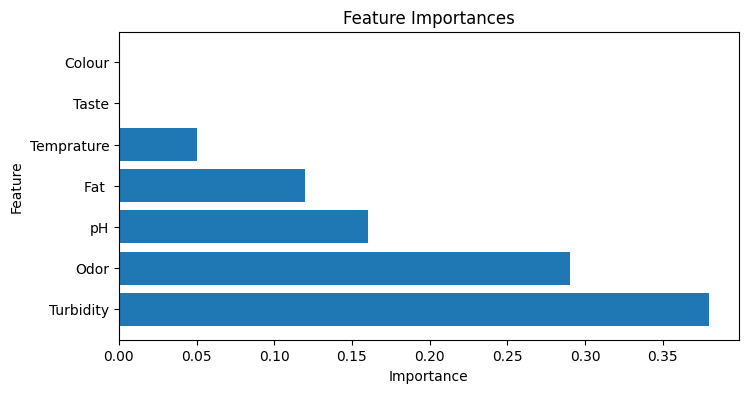

In [55]:
# Get feature importances
# feature_importances = rf_classifier.feature_importances_  # manual CV
feature_importances = model_best_params.feature_importances_  # using GridSearch

# Get the corresponding feature names
feature_names = list(X_trn.columns)  # Assuming you have column names in your DataFrame X

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
display(importance_df)

# Plotting feature importances (optional)
plt.figure(figsize=(8, 4))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

## Performance on Test data

In [56]:
# Make predictions on the test set
y_test_pred = model_best_params.predict(X_tst_scale)

# Evaluate the model
accuracy = accuracy_score(y_tst, y_test_pred)
print(f"Accuracy: {accuracy}")

# Display classification report
print("Classification Report:")
print(classification_report(y_tst, y_test_pred))

Accuracy: 0.9198113207547169
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        86
           1       0.86      0.95      0.90        75
           2       0.90      0.75      0.82        51

    accuracy                           0.92       212
   macro avg       0.92      0.90      0.90       212
weighted avg       0.92      0.92      0.92       212



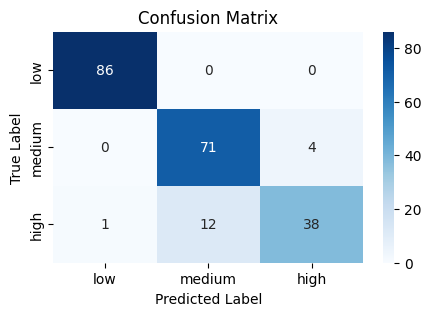

In [57]:
# Get the confusion matrix
conf_matrix = confusion_matrix(y_tst, y_test_pred)

# Display the confusion matrix using a heatmap
class_names = ['low', 'medium', 'high']
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# EDA Error (Testing dataset)

In [58]:
# Merge prediction with the testing dataset
df_test_perf = y_tst.copy()
df_test_perf['pred_test'] = y_test_pred
df_test_perf = X_tst.merge(df_test_perf, left_index=True, right_index=True)

# Explore Error
df_error = df_test_perf[df_test_perf['Grade']!=df_test_perf['pred_test']]
print(f"Number of False Prediction: {df_error.shape[0]} ({(100*df_error.shape[0]/y_tst.shape[0]):.02f}%)")
df_test_perf[df_test_perf['Grade']!=df_test_perf['pred_test']]

Number of False Prediction: 17 (8.02%)


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade,pred_test
index,,,,,,,,,
338,6.7,45,1,1,1,0,245,1,2
429,6.7,38,1,0,1,0,255,2,1
649,6.6,37,1,0,1,0,255,2,1
466,6.7,45,1,1,1,0,245,1,2
990,6.6,37,1,0,1,0,255,2,1
1,6.6,36,0,1,0,1,253,2,0
897,6.7,38,1,0,1,0,255,2,1
193,6.7,38,1,0,1,0,255,2,1
939,6.7,45,1,1,1,0,245,1,2
